<a href="https://colab.research.google.com/github/CrisBarrera/CursoIntroPython/blob/main/Financial_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




La urgencia por detectar fraudes en transacciones móviles de dinero ha llevado a una empresa del segmento Fintech a buscar soluciones innovadoras. Como científicos de datos hemos sido convocados para desarrollar un modelo de machine learning que pueda distinguir de manera precisa entre transacciones legítimas y fraudulentas, estableciendo así un estándar de seguridad en el sector financiero móvil global.

### **Tus tareas principales serán:**

**1. Preprocesamiento de Datos:** Realizar limpieza de datos, manejar valores faltantes, codificación de variables categóricas y normalización/escalado de datos.

**2. Exploración de Datos:** Analizar y comprender el conjunto de datos proporcionado, identificar variables llaves y realizar visualizaciones para entender las relaciones entre las variables y seleccionar las características relevantes.

**3. Construcción de Modelos:** Experimentar con algunos algoritmos de machine learning como Regresión Logística, Árboles de Decisión, Random Forest, Naive Bayes, entre otros.

**4. Evaluación y Selección del Modelo:** Evaluar los modelos utilizando métricas como precisión, recall, área bajo la curva ROC, y F1-score. Seleccionar el modelo con el mejor rendimiento para la detección de transacciones bancarias fraudulentas.

#**1. Configuración del Ambiente**


---




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
pd.set_option('display.max_columns', None)
!pip install -U imbalanced-learn
!pip install ydata-profiling
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
global df_banco, resultados

#**2. Preprocesamiento de Datos**


---


**Enlacemos la Base de Datos al Notebooky echemos un vistazo:**

In [ ]:
df_banco = pd.read_csv("https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/fraud_dataset_example.csv")
df_banco.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            101613 non-null  int64  
 1   type            101613 non-null  object 
 2   amount          101613 non-null  float64
 3   nameOrig        101613 non-null  object 
 4   oldbalanceOrg   101613 non-null  float64
 5   newbalanceOrig  101613 non-null  float64
 6   nameDest        101613 non-null  object 
 7   oldbalanceDest  101613 non-null  float64
 8   newbalanceDest  101613 non-null  float64
 9   isFraud         101613 non-null  int64  
 10  isFlaggedFraud  101613 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.5+ MB


**Columnas**

**Step:** Es una medida de tiempo, cada número representa una hora del mes, en este caso hay valores de 1-10.

**Type:** Nos indica el tipo de transacción, CASH_OUT (Retiro), CASH_IN (Depósito), DEBIT (DÉBITO), PAYMENT (Pago) y TRANSFER (Transferencia).

**Amount:** Monto de la transacción ($).

**nameOrig:** Nos indica el origen de la transacción.

**oldbalanceOrg:** Indica el balance anterior de la cuenta de origen.

**newbalanceOrig:** Indica el balance nuevo de la cuenta de origen.

**nameDest:** Nos indica el destinatario de la transacción.

**oldbalanceDest:** Nos indica el balance anterior del destinatario.

**newbalanceDest:** Indica el nuevo balance del destinatario.

**isFraud:** Nos indica si es fraude o no fraude.

**isFlaggedFraud:** Indica si es fraude potencial o no.

**Creamos una función para procesar los datos exportados**

In [ ]:
#Función Procesar Datos
def procesar_datos():
  global df_banco

  #Crear Variables
  df_banco['type2'] = df_banco['nameOrig'].str[0] + df_banco['nameDest'].str[0]

  #One Hot Encoding a type y type2, Añadir Columnas al Dataframe
  df_banco = pd.get_dummies(df_banco, columns=['type', 'type2'], dtype=int)

  #Eliminar Columnas Seleccionadas
  columnas = ['nameOrig', 'nameDest', 'isFlaggedFraud', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
  df_banco.drop(columnas, axis=1, inplace=True)

  #Eliminar Duplicados y Nulos
  df_banco.drop_duplicates(inplace=True)
  df_banco.dropna(inplace=True)

In [ ]:
#Llamar función y examinar dataframe
procesar_datos()
df_banco.head()

,step,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,0,0,0,0,1,0,0,1
1,1,1864.28,0,0,0,0,1,0,0,1
2,1,181.00,1,0,0,0,0,1,1,0
3,1,181.00,1,0,1,0,0,0,1,0
4,1,11668.14,0,0,0,0,1,0,0,1


In [ ]:
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101518 entries, 0 to 101612
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   step           101518 non-null  int64  
 1   amount         101518 non-null  float64
 2   isFraud        101518 non-null  int64  
 3   type_CASH_IN   101518 non-null  int64  
 4   type_CASH_OUT  101518 non-null  int64  
 5   type_DEBIT     101518 non-null  int64  
 6   type_PAYMENT   101518 non-null  int64  
 7   type_TRANSFER  101518 non-null  int64  
 8   type2_CC       101518 non-null  int64  
 9   type2_CM       101518 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 8.5 MB


Hemos eliminado columnas que consideramos no relevantes y hemos hecho separación de columnas por tipo de transacción y tipo de destinatario.

#**3. Exploración de Datos**


---


In [ ]:
#ProfileReport(df_banco)

**Exploremos los datos del dataframe mediante visualizaciones que podamos encontrar.**

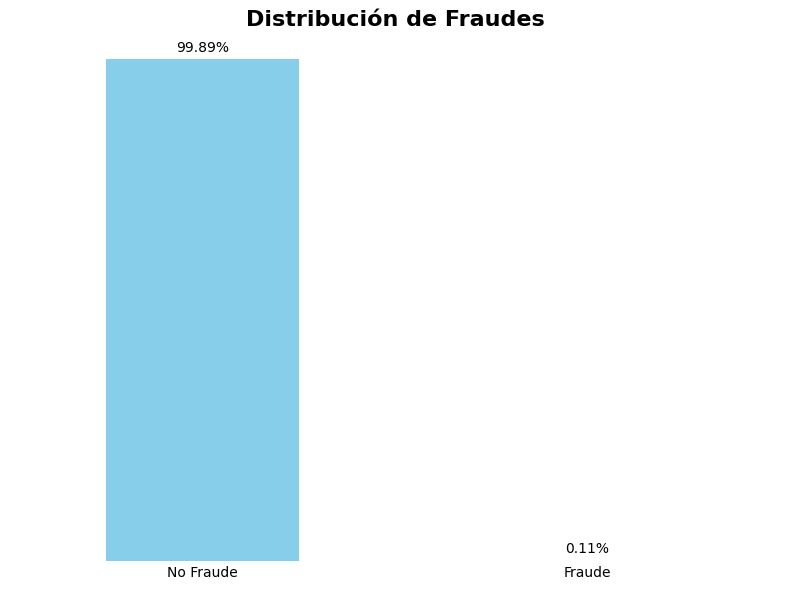

In [ ]:
# @title
conteo = df_banco['isFraud'].value_counts()

#Crear el gráfico
plt.figure(figsize=(8, 6))
ax = conteo.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='none')
plt.title('Distribución de Fraudes', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0, 1], ['No Fraude', 'Fraude'], rotation=0)
plt.tick_params(axis='y', which='both', left=False)

#Ocultar línea superior y derecha del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)

#Agregar porcentaje
total = sum(conteo)
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 1500, f"{round((i.get_height() / total) * 100, 2)}%", ha='center')

plt.tight_layout()
plt.show()

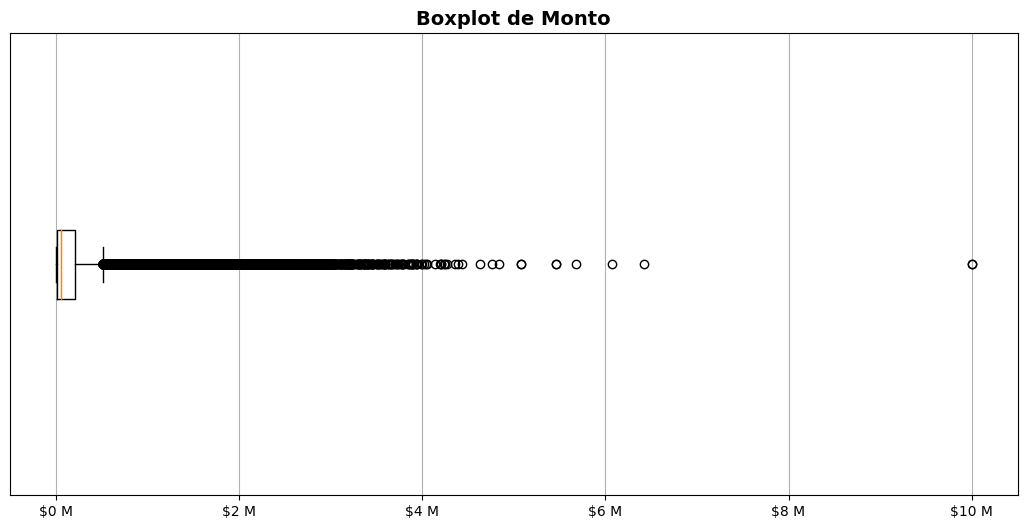

In [ ]:
# @title
#Crear el boxplot de la variable 'amount'
plt.figure(figsize=(13, 6))
plt.boxplot(df_banco['amount'], vert=False)
plt.title('Boxplot de Monto', fontsize=14, fontweight='bold')
plt.yticks([])
plt.grid(axis='x')
formatter = ticker.FuncFormatter(lambda x, _: f'${x / 1e6:.0f} M')
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

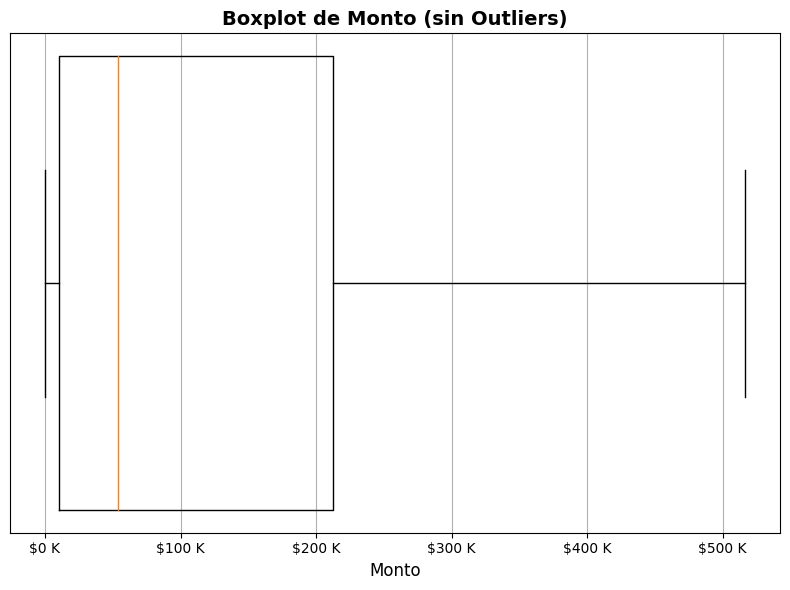

In [ ]:
# @title
#Crear el boxplot 'amount' snin outliers
plt.figure(figsize=(8, 6))
plt.boxplot(df_banco['amount'], vert=False, showfliers=False, widths=10)
plt.title('Boxplot de Monto (sin Outliers)', fontsize=14, fontweight='bold')
plt.xlabel('Monto', fontsize=12)
plt.yticks([])
plt.grid(axis='x')
formatter = ticker.FuncFormatter(lambda x, _: f'${x / 1e3:.0f} K')
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

**De los gráficos anteriores podemos concluir:**

*   Existe un **desbalanceo** muy grande entre la variable objetivo, es necesario hacer un **balanceo** mas adelante para obtener un mejor modelo.
*   Tenemos **demasiados outliers** en los **montos** de las transacciones, sin embargo la mayor concentración segun el boxplot, sin considerar outliers, se encuentra entre **10K y 210K**.

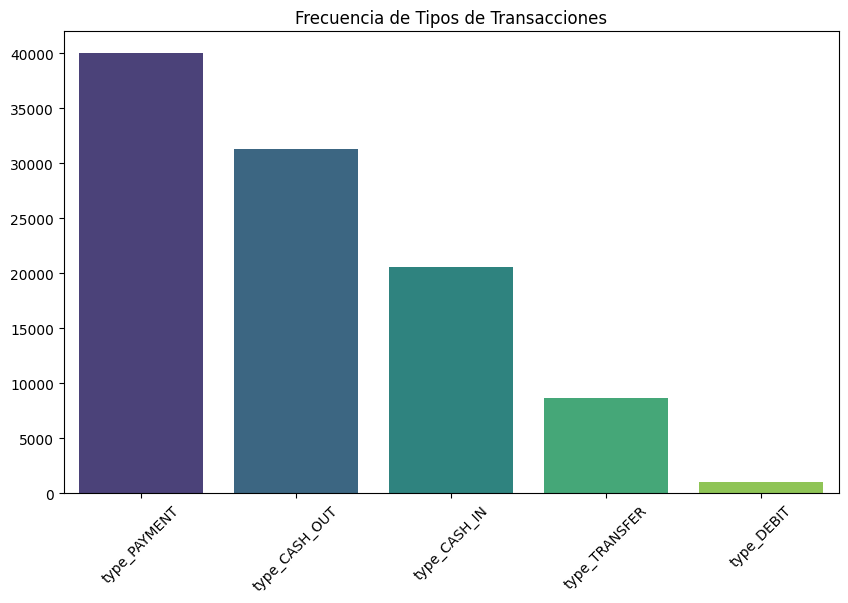

In [ ]:
# @title
# Contar la frecuencia de cada tipo de transacción
frecuencia_tipos = df_banco[['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].sum()

# Ordenar los valores de frecuencia de mayor a menor
frecuencia_tipos_sorted = frecuencia_tipos.sort_values(ascending=False)

# Crear el barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=frecuencia_tipos_sorted.index, y=frecuencia_tipos_sorted.values, palette='viridis')
plt.title('Frecuencia de Tipos de Transacciones')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

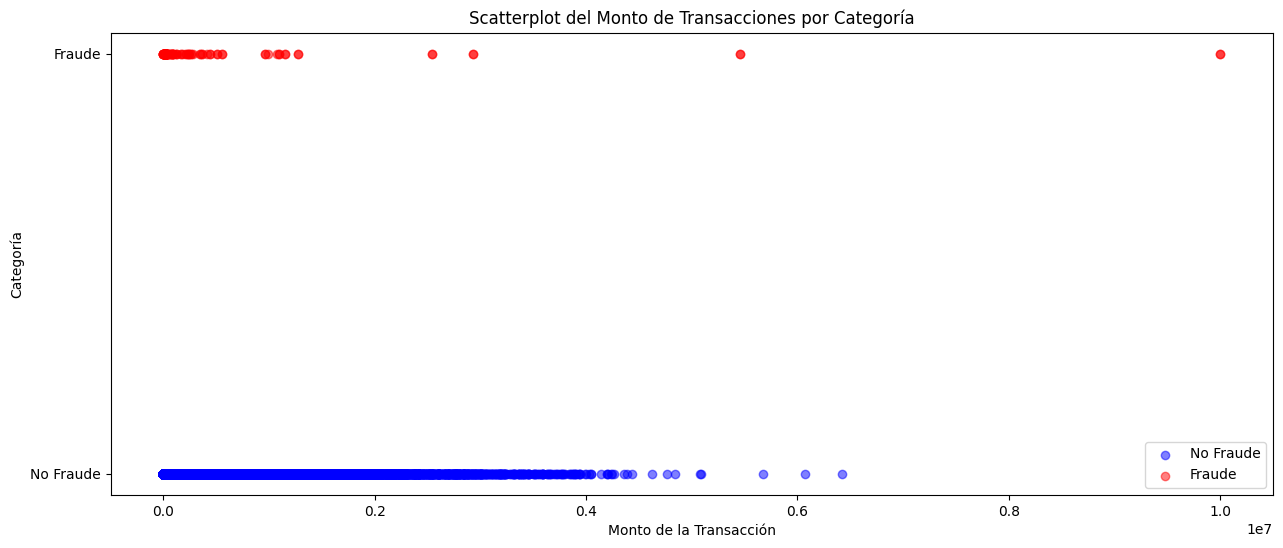

In [ ]:
# @title
# Dividir el DataFrame en transacciones fraudulentas y no fraudulentas
transacciones_no_fraudulentas = df_banco[df_banco['isFraud'] == 0]
transacciones_fraudulentas = df_banco[df_banco['isFraud'] == 1]

# Crear el scatterplot para visualizar los montos de las transacciones
plt.figure(figsize=(15, 6))
plt.scatter(transacciones_no_fraudulentas['amount'], [0]*len(transacciones_no_fraudulentas), color='blue', label='No Fraude', alpha=0.5)
plt.scatter(transacciones_fraudulentas['amount'], [1]*len(transacciones_fraudulentas), color='red', label='Fraude', alpha=0.5)
plt.xlabel('Monto de la Transacción')
plt.ylabel('Categoría')
plt.title('Scatterplot del Monto de Transacciones por Categoría')
plt.yticks([0, 1], ['No Fraude', 'Fraude'])
plt.legend()
plt.show()

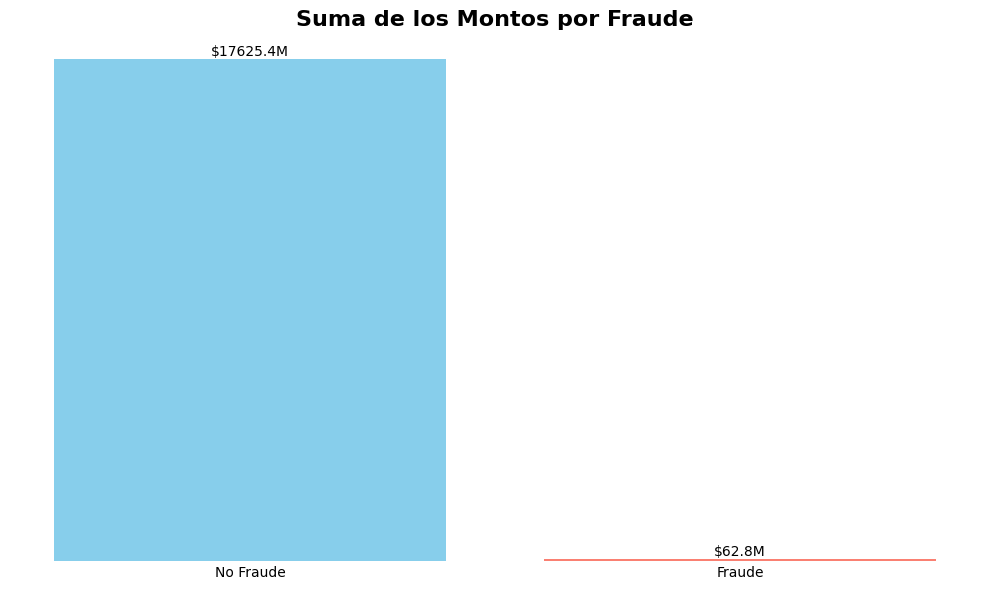

In [ ]:
# @title
#Calcular la suma de 'amount' por fraude
suma_no_fraude = df_banco[df_banco['isFraud'] == 0]['amount'].sum() / 1e6
suma_fraude = df_banco[df_banco['isFraud'] == 1]['amount'].sum() / 1e6

#Crear el histograma
plt.figure(figsize=(10, 6))
barplot = plt.bar(['No Fraude', 'Fraude'], [suma_no_fraude, suma_fraude], color=['skyblue', 'salmon'])
plt.title('Suma de los Montos por Fraude', fontsize=16, fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)

#Agregar el monto
for bar, monto in zip(barplot, [suma_no_fraude, suma_fraude]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'${monto:.1f}M', ha='center', va='bottom')

plt.tight_layout()
plt.show()

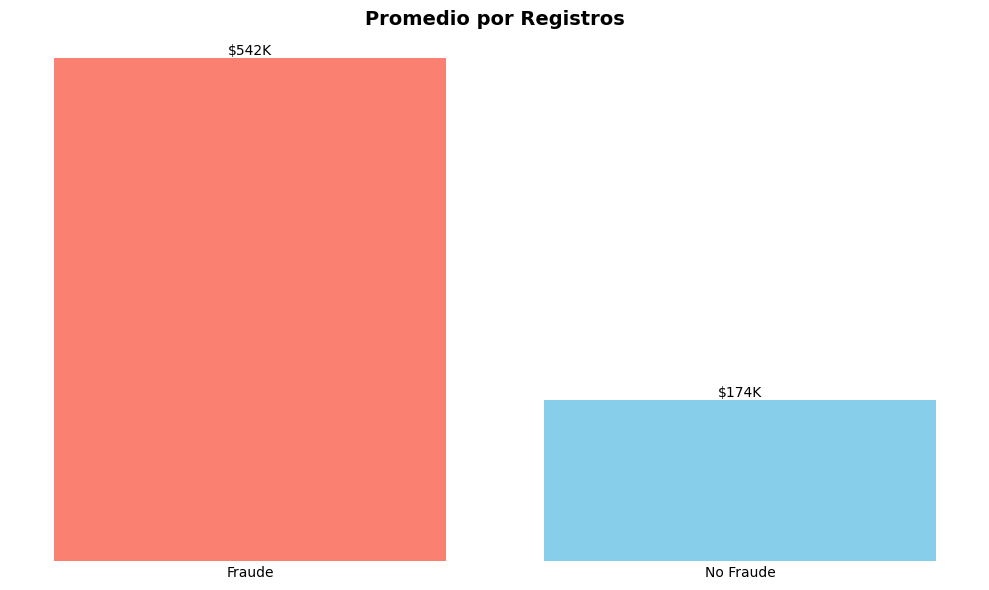

In [ ]:
# @title
#Calcula la suma de los montos para registros de fraude y no fraude
suma_montos_fraude = df_banco[df_banco['isFraud'] == 1]['amount'].sum()/1e3
suma_montos_no_fraude = df_banco[df_banco['isFraud'] == 0]['amount'].sum()/1e3

#Calcula el número de registros de fraude y no fraude
registros_fraude = df_banco['isFraud'].sum()
registros_no_fraude = len(df_banco) - registros_fraude

#Calcula el promedio por registros
razon_fraude = suma_montos_fraude / registros_fraude
razon_no_fraude = suma_montos_no_fraude / registros_no_fraude

#Grafica la razón entre la suma de montos y el número de registros para fraude y no fraude
plt.figure(figsize=(10, 6))
barplot = plt.bar(['Fraude', 'No Fraude'], [razon_fraude, razon_no_fraude], color=['salmon', 'skyblue'])
plt.title('Promedio por Registros', fontsize=14, fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)


#Agrega etiquetas con el número encima de cada barra
for barra in barplot:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width() / 2, altura + 0.05, f'${altura:.0f}K', ha='center', va='bottom')

plt.gca().axes.yaxis.set_ticklabels([])
plt.tight_layout()
plt.show()

**De los dos gráficos anteriores:**

*   Aunque son pocos registros por fraude, la suma de los montos asciende a los **62.8M** una cantidad fuerte al ser pocos datos.
*   De los registros que son fraudulentos, el promedio es de **$542K**, lo que es aproximadamente 3.11 veces mas que el promedio de los registros no fraudulentos.



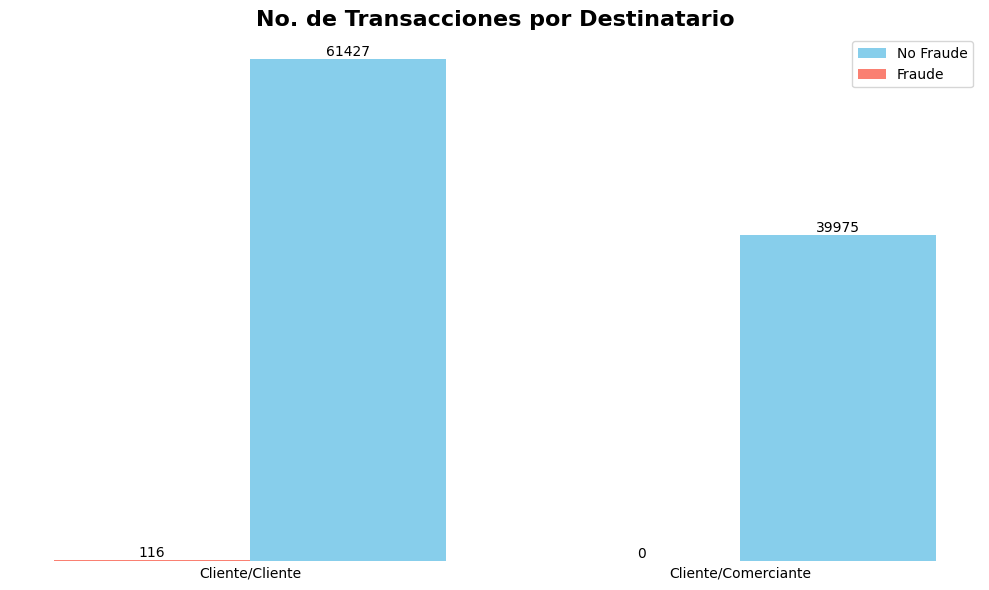

In [ ]:
# @title
#Calcular el no. total de transacciones fraudulentas y no fraudulentas por tipo de destinatario
recuento_por_tipo_fraude = df_banco[df_banco['isFraud'] == 1][['type2_CC', 'type2_CM']].sum()
recuento_por_tipo_no_fraude = df_banco[df_banco['isFraud'] == 0][['type2_CC', 'type2_CM']].sum()
plt.figure(figsize=(10, 6))

#Graficar barras para transacciones fraudulentas y no fraudulentas
bar_width = 0.4
bar_index = np.arange(len(recuento_por_tipo_fraude))

plt.bar(bar_index + bar_width/2, recuento_por_tipo_no_fraude, bar_width, label='No Fraude', color='skyblue')
plt.bar(bar_index - bar_width/2, recuento_por_tipo_fraude, bar_width, label='Fraude', color='salmon')

plt.title('No. de Transacciones por Destinatario', fontsize=16, fontweight='bold')
nombres_xticks = ['Cliente/Cliente', 'Cliente/Comerciante']
plt.xticks(bar_index, nombres_xticks)
plt.legend()

#Agregar etiquetas con el número de transacciones encima de cada barra
for i, valor in enumerate(recuento_por_tipo_fraude):
    plt.text(i - bar_width/2, valor + 3, str(valor), ha='center', va='bottom')

for i, valor in enumerate(recuento_por_tipo_no_fraude):
    plt.text(i + bar_width/2, valor + 3, str(valor), ha='center', va='bottom')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

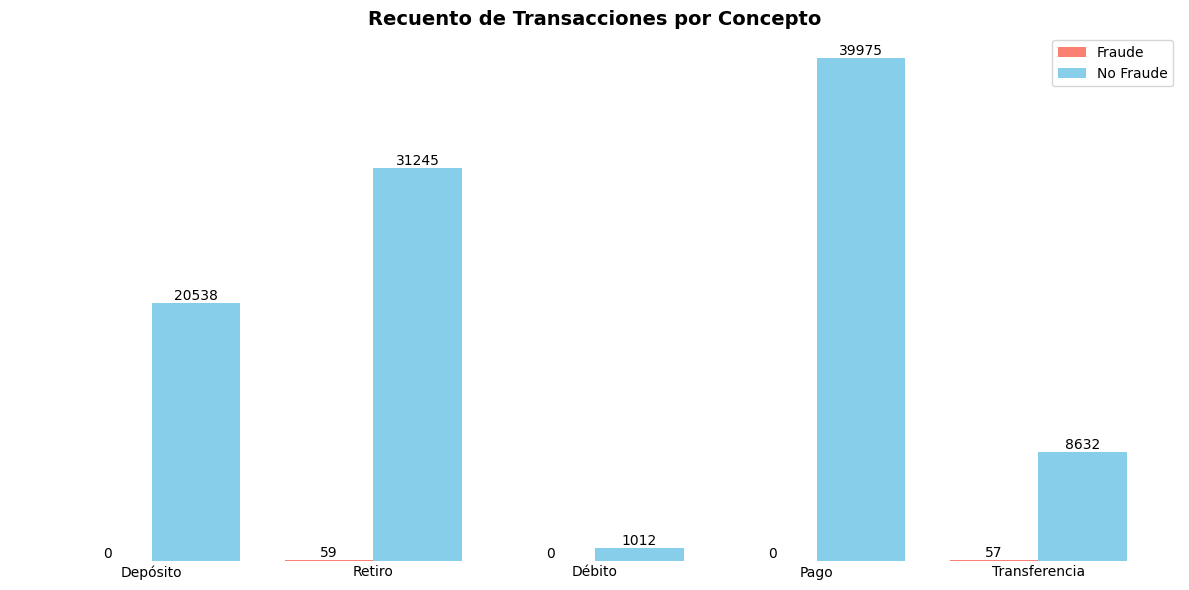

In [ ]:
# @title
#Calcular el no. total de transacciones por tipo para transacciones fraudulentas y no fraudulentas
recuento_total_fraude_por_tipo = df_banco[df_banco['isFraud'] == 1][['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].sum()
recuento_total_no_fraude_por_tipo = df_banco[df_banco['isFraud'] == 0][['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].sum()

#Crear el gráfico de barras
plt.figure(figsize=(12, 6))

#Graficar barras para transacciones fraudulentas y no fraudulentas
bar_width = 0.4
bar_index = np.arange(len(recuento_total_fraude_por_tipo))

plt.bar(bar_index - bar_width/2, recuento_total_fraude_por_tipo, bar_width, label='Fraude', color='salmon')
plt.bar(bar_index + bar_width/2, recuento_total_no_fraude_por_tipo, bar_width, label='No Fraude', color='skyblue')

plt.title('Recuento de Transacciones por Concepto', fontsize=14, fontweight='bold')
nuevas_etiquetas = ['Depósito', 'Retiro', 'Débito', 'Pago', 'Transferencia']
plt.xticks(bar_index, nuevas_etiquetas, rotation=0)

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)

#Agregar etiquetas con el número de transacciones encima de cada barra
for i in range(len(bar_index)):
    plt.text(bar_index[i] - bar_width/2, recuento_total_fraude_por_tipo[i] + 5, str(recuento_total_fraude_por_tipo[i]), ha='center', va='bottom')
    plt.text(bar_index[i] + bar_width/2, recuento_total_no_fraude_por_tipo[i] + 5, str(recuento_total_no_fraude_por_tipo[i]), ha='center', va='bottom')

plt.tight_layout()
plt.show()

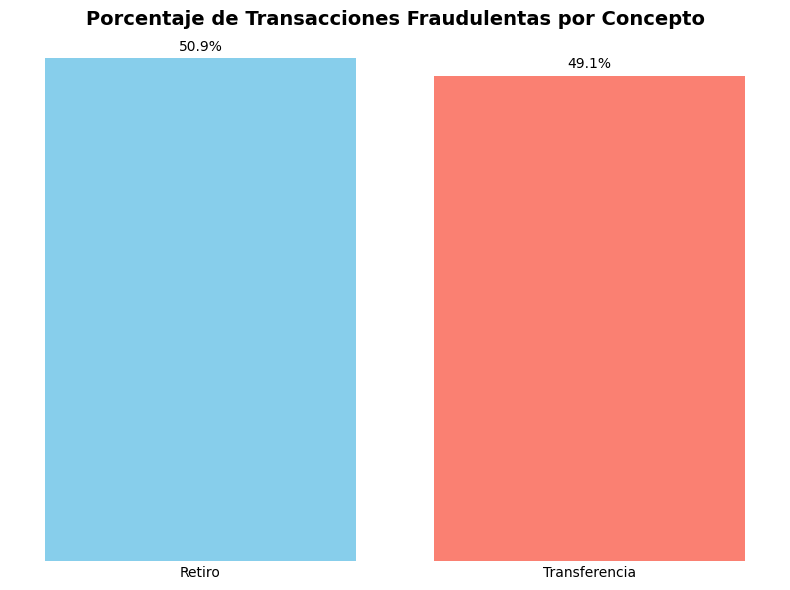

In [ ]:
# @title
#Calcular el no. total de transacciones fraudulentas por tipo
recuento_total_fraude_por_tipo = df_banco[df_banco['isFraud'] == 1][['type_CASH_OUT', 'type_TRANSFER']].sum()

#Calcular el total de transacciones fraudulentas
total_fraude = recuento_total_fraude_por_tipo.sum()

#Calcular los porcentajes de transacciones fraudulentas que son CASH_OUT y TRANSFER
porcentaje_cash_out = (recuento_total_fraude_por_tipo['type_CASH_OUT'] / total_fraude) * 100
porcentaje_transfer = (recuento_total_fraude_por_tipo['type_TRANSFER'] / total_fraude) * 100

fig, ax = plt.subplots(figsize=(8, 6))

x = ['Retiro', 'Transferencia']
x_pos = range(len(x))

#Graficar las barras
ax.bar(x_pos, [porcentaje_cash_out, porcentaje_transfer], color=['skyblue', 'salmon'])

#Agregar etiquetas de porcentaje en cada barra
for i, v in enumerate([porcentaje_cash_out, porcentaje_transfer]):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

ax.set_xticks(x_pos)
ax.set_xticklabels(x)

ax.set_title('Porcentaje de Transacciones Fraudulentas por Concepto', fontsize=14, fontweight='bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

In [ ]:
#Verificación de información
no_fraude, fraude = df_banco['isFraud'].value_counts()
print(f'Los registros NO fraudulentos son: {no_fraude}\nLos registros fraudulentos son: {fraude}')

Los registros NO fraudulentos son: 101402
Los registros fraudulentos son: 116




*   Sólo tenemos **116 registros** catalogados como **fraude**, de los cuales fueron de cliente a cliente.
*   De dichos registros, el **51%** pertenece a transacciones por **Retiro** y el **49.1%** por **Transferencia**.

Es interesenta notar que no hay transacciones fraudulentas por Cliente a Comercio, ni por los conceptos de: Depósito, Débito, Pago.

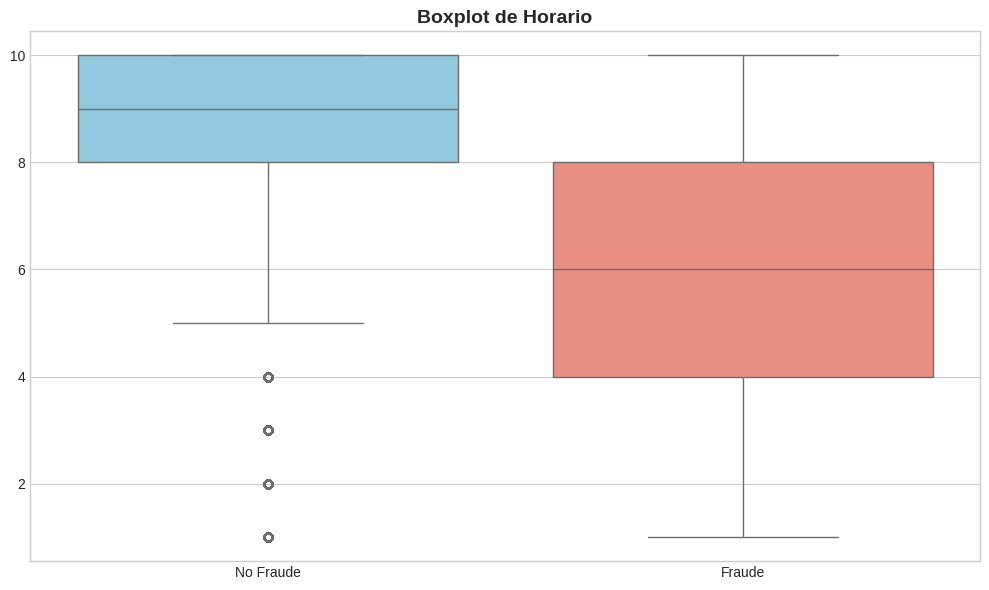

In [ ]:
# @title
plt.style.use('seaborn-whitegrid')
#Gráfico de boxplot para 'step'
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='step', data=df_banco, palette=['skyblue', 'salmon'])
plt.title('Boxplot de Horario', fontsize=14, fontweight='bold')
plt.xticks([0, 1], ['No Fraude', 'Fraude'])
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

En el Boxplot de horario se observa una distribución uniforme en transacciones fraudulentas, mientras que en las transacciones NO fraudulentas la distribución se encuentra entre 5 y 10.

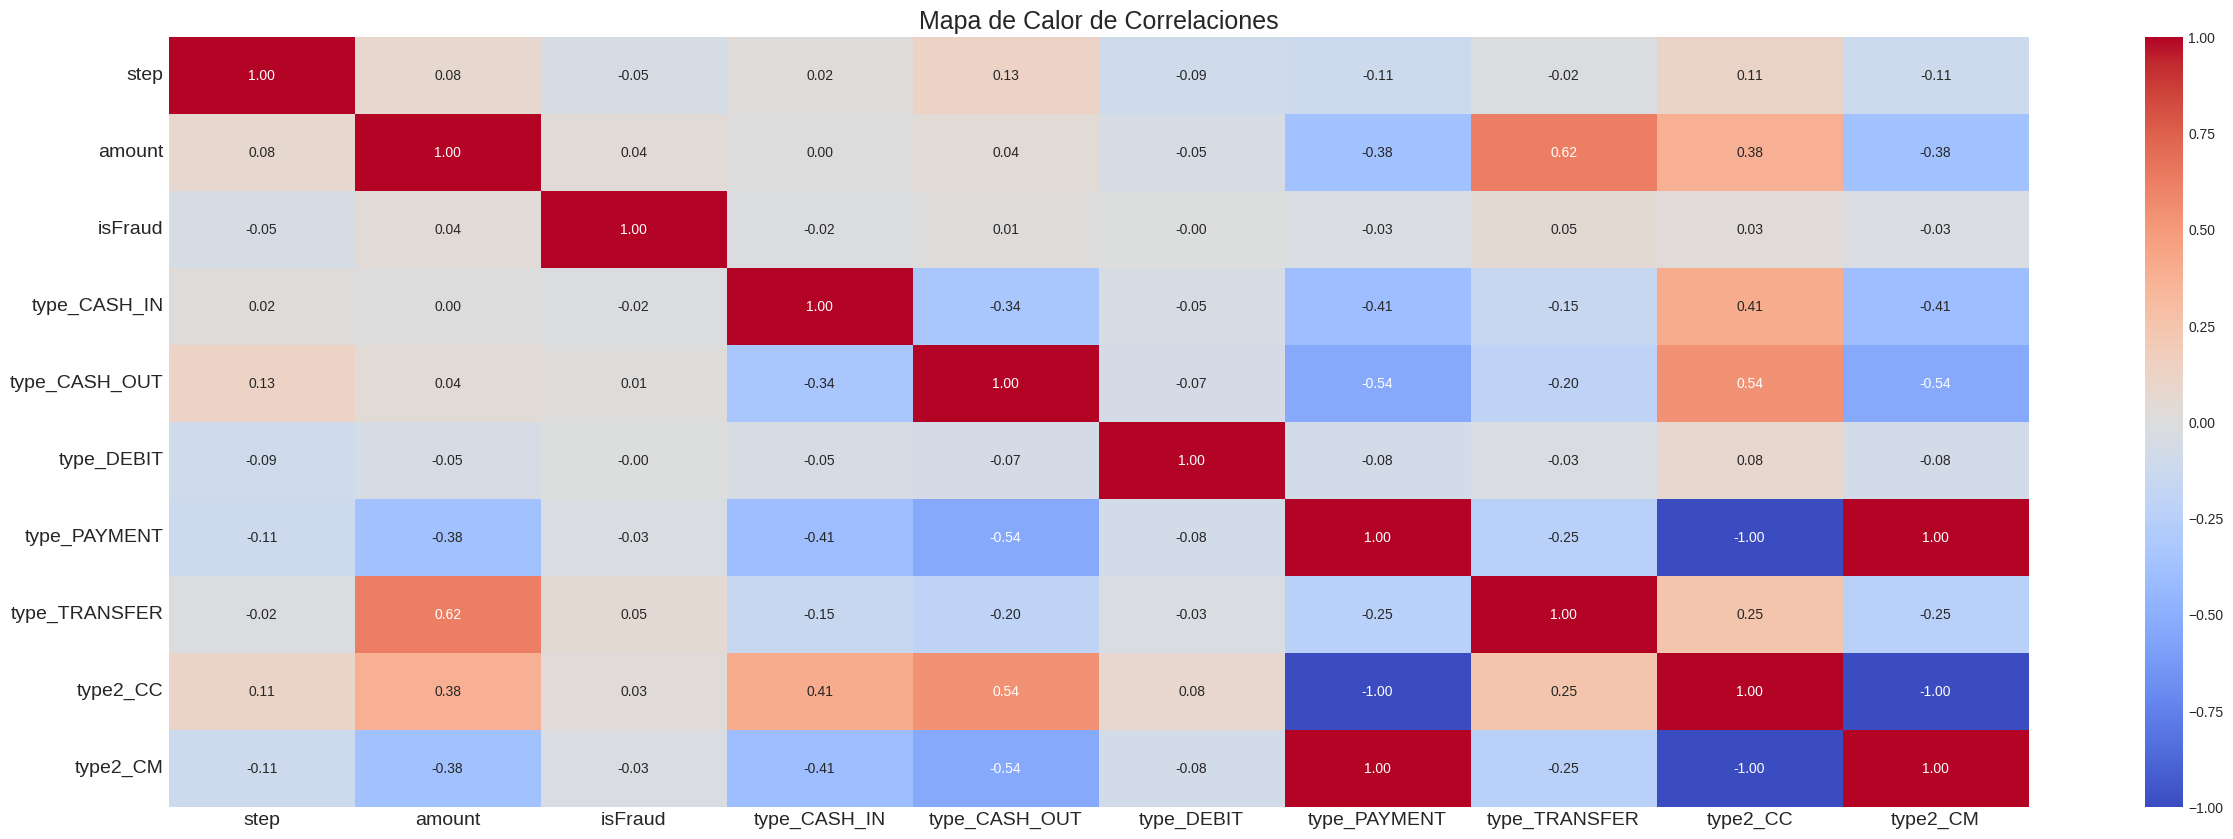

In [ ]:
# @title
#Mapa de calor
plt.figure(figsize=(30, 10))
heatmap = sns.heatmap(df_banco.corr(), annot=True, cmap='coolwarm', fmt=".2f")
heatmap.tick_params(axis='both', which='major', labelsize=14)
plt.title('Mapa de Calor de Correlaciones', fontsize=18)
plt.show()

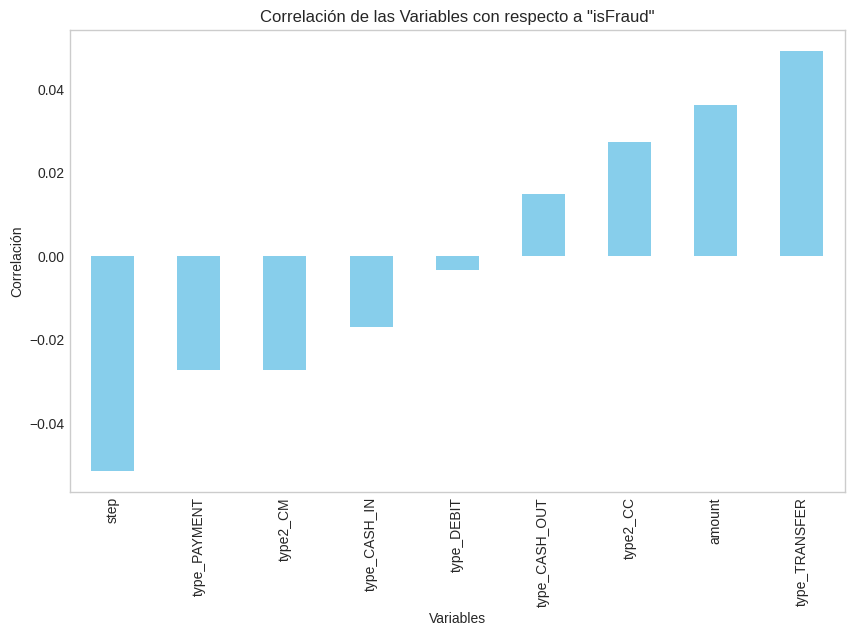

In [ ]:
# @title
# Correlación de las variables respecto a 'isFraud' excluyendo la correlación con 'isFraud' misma
correlation_series = df_banco.corr()['isFraud'].drop('isFraud')

# Graficar la correlación
plt.figure(figsize=(10, 6))
correlation_series.sort_values().plot(kind='bar', color='skyblue')
plt.title('Correlación de las Variables con respecto a "isFraud"')
plt.xlabel('Variables')
plt.grid(False)
plt.ylabel('Correlación')
plt.show()

**Hagamos el balanceo del conjunto de datos para tener un numero cercano de las clases fraude y no fraude.**

In [ ]:
#Función de balanceo de clases
def balanceo_clases():
  global df_banco

  #Aplicar SMOTE
  smote = SMOTE()
  X = df_banco.drop('isFraud', axis=1)
  y = df_banco['isFraud']
  X_resampled, y_resampled = smote.fit_resample(X, y)

  #Crear un nuevo df
  df_banco_balanceado = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['isFraud'])], axis=1)

  #Eliminar duplicados
  df_banco_balanceado.drop_duplicates(inplace=True)

  #Actualizar df
  df_banco = df_banco_balanceado

In [ ]:
balanceo_clases()
#ProfileReport(df_banco)

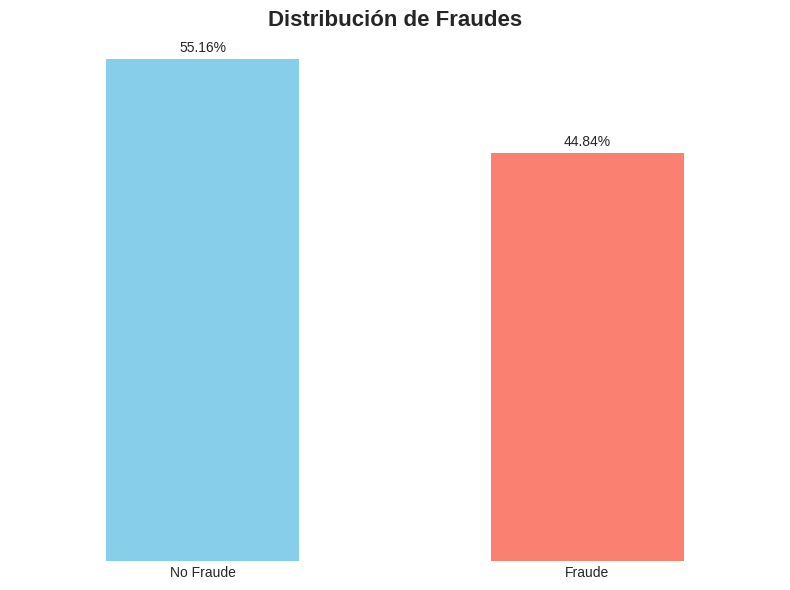

In [ ]:
conteo = df_banco['isFraud'].value_counts()

#Crear el gráfico
plt.figure(figsize=(8, 6))
ax = conteo.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='none')
plt.title('Distribución de Fraudes', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0, 1], ['No Fraude', 'Fraude'], rotation=0)
plt.tick_params(axis='y', which='both', left=False)

#Ocultar línea superior y derecha del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)

#Agregar porcentaje
total = sum(conteo)
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 1500, f"{round((i.get_height() / total) * 100, 2)}%", ha='center')

plt.grid(False)
plt.tight_layout()
plt.show()

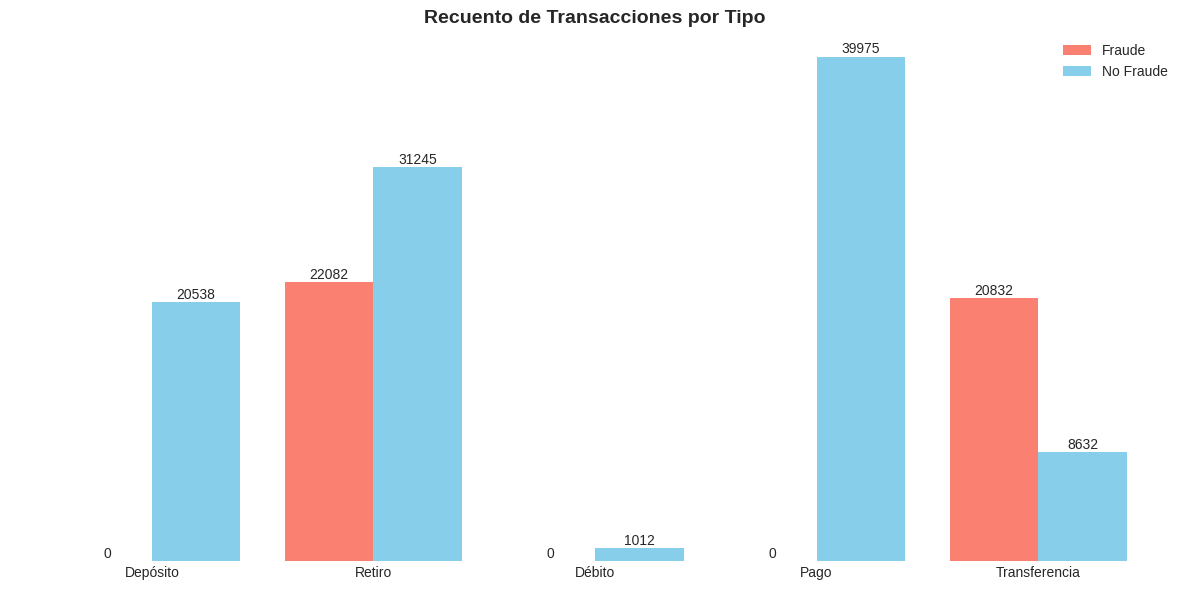

In [ ]:
# Calcular el recuento total de transacciones por tipo para transacciones fraudulentas y no fraudulentas
recuento_total_fraude_por_tipo = df_banco[df_banco['isFraud'] == 1][['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].sum()
recuento_total_no_fraude_por_tipo = df_banco[df_banco['isFraud'] == 0][['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].sum()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))

# Graficar barras para transacciones fraudulentas y no fraudulentas
bar_width = 0.4
bar_index = np.arange(len(recuento_total_fraude_por_tipo))

plt.bar(bar_index - bar_width/2, recuento_total_fraude_por_tipo, bar_width, label='Fraude', color='salmon')
plt.bar(bar_index + bar_width/2, recuento_total_no_fraude_por_tipo, bar_width, label='No Fraude', color='skyblue')

plt.title('Recuento de Transacciones por Tipo', fontsize=14, fontweight='bold')
nuevas_etiquetas = ['Depósito', 'Retiro', 'Débito', 'Pago', 'Transferencia']  # Lista de nombres personalizados
plt.xticks(bar_index, nuevas_etiquetas, rotation=0)

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis='both', which='both', length=0)

# Agregar etiquetas con el número de transacciones encima de cada barra
for i in range(len(bar_index)):
    plt.text(bar_index[i] - bar_width/2, recuento_total_fraude_por_tipo[i] + 5, str(recuento_total_fraude_por_tipo[i]), ha='center', va='bottom')
    plt.text(bar_index[i] + bar_width/2, recuento_total_no_fraude_por_tipo[i] + 5, str(recuento_total_no_fraude_por_tipo[i]), ha='center', va='bottom')


plt.grid(False)
plt.tight_layout()
plt.show()

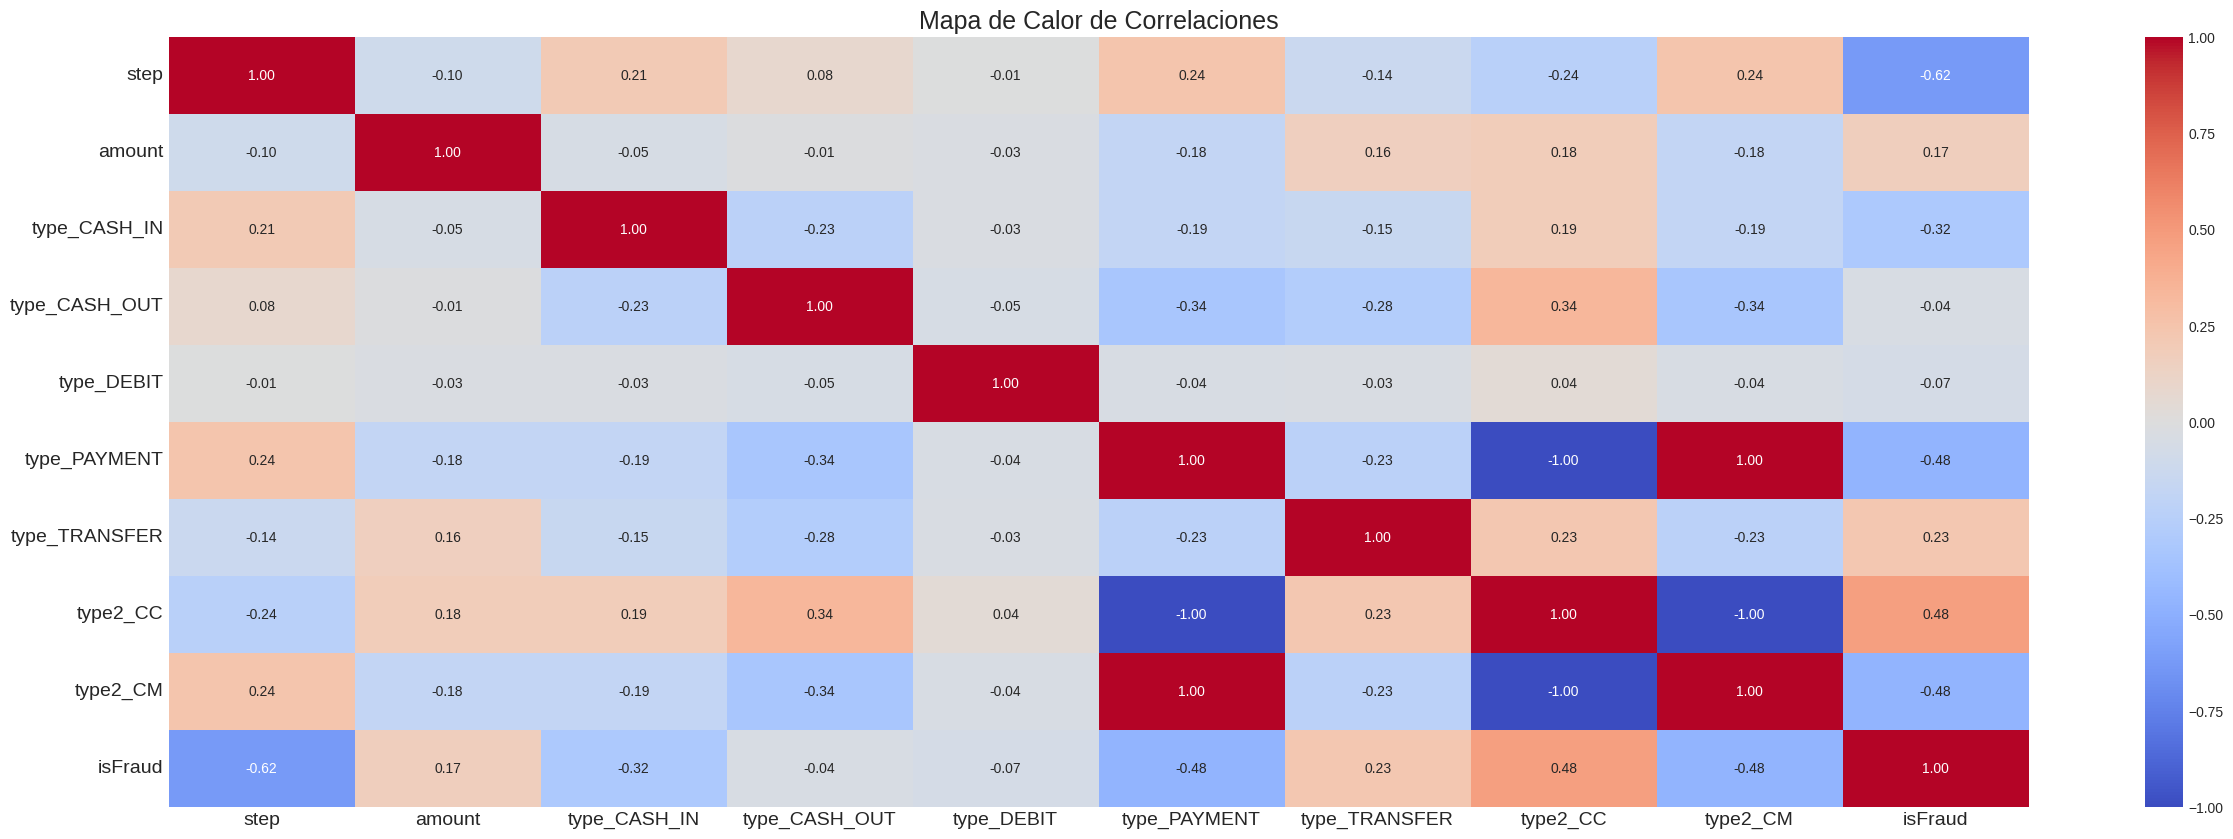

In [ ]:
#Mapa de calor nuevo
plt.figure(figsize=(30, 10))
heatmap = sns.heatmap(df_banco.corr(), annot=True, cmap='coolwarm', fmt=".2f")
heatmap.tick_params(axis='both', which='major', labelsize=14)
plt.title('Mapa de Calor de Correlaciones', fontsize=18)
plt.show()

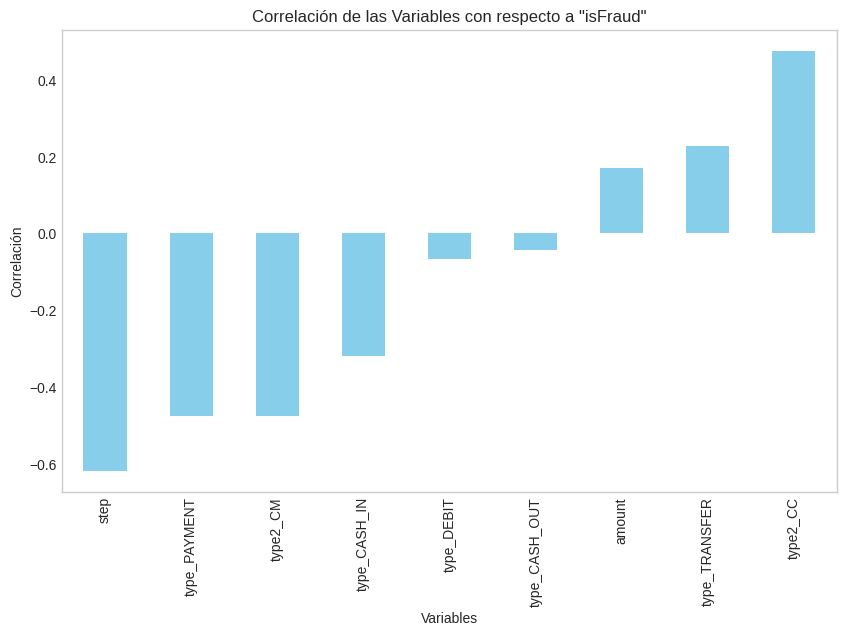

In [ ]:
# Correlación de las variables respecto a 'isFraud' excluyendo la correlación con 'isFraud' misma
correlation_series = df_banco.corr()['isFraud'].drop('isFraud')

# Graficar la correlación
plt.figure(figsize=(10, 6))
correlation_series.sort_values().plot(kind='bar', color='skyblue')
plt.title('Correlación de las Variables con respecto a "isFraud"')
plt.xlabel('Variables')
plt.grid(False)
plt.ylabel('Correlación')
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Crear un DataFrame con las variables independientes (sin la variable objetivo)
X = df_banco.drop(columns='isFraud')

# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Mostrar el DataFrame con los resultados del VIF
print(vif_data)

        Variable       VIF
0           step  1.263859
1         amount  1.064136
2   type_CASH_IN  1.567611
3  type_CASH_OUT  1.852533
4     type_DEBIT  1.024170
5   type_PAYMENT       inf
6  type_TRANSFER  1.495274
7       type2_CC  8.025785
8       type2_CM       inf


In [ ]:
columnas_irrelevantes = ['type2_CM', 'type2_CC']
df_banco.drop(columnas_irrelevantes, axis=1, inplace=True)
df_banco.head()

,step,amount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,1,9839.64,0,0,0,1,0,0
1,1,1864.28,0,0,0,1,0,0
2,1,181.00,0,0,0,0,1,1
3,1,181.00,0,1,0,0,0,1
4,1,11668.14,0,0,0,1,0,0


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Crear un DataFrame con las variables independientes (sin la variable objetivo)
X = df_banco.drop(columns='isFraud')

# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Mostrar el DataFrame con los resultados del VIF
print(vif_data)

        Variable       VIF
0           step  5.205346
1         amount  1.161203
2   type_CASH_IN  1.738052
3  type_CASH_OUT  2.407208
4     type_DEBIT  1.023406
5   type_PAYMENT  2.359905
6  type_TRANSFER  1.582853


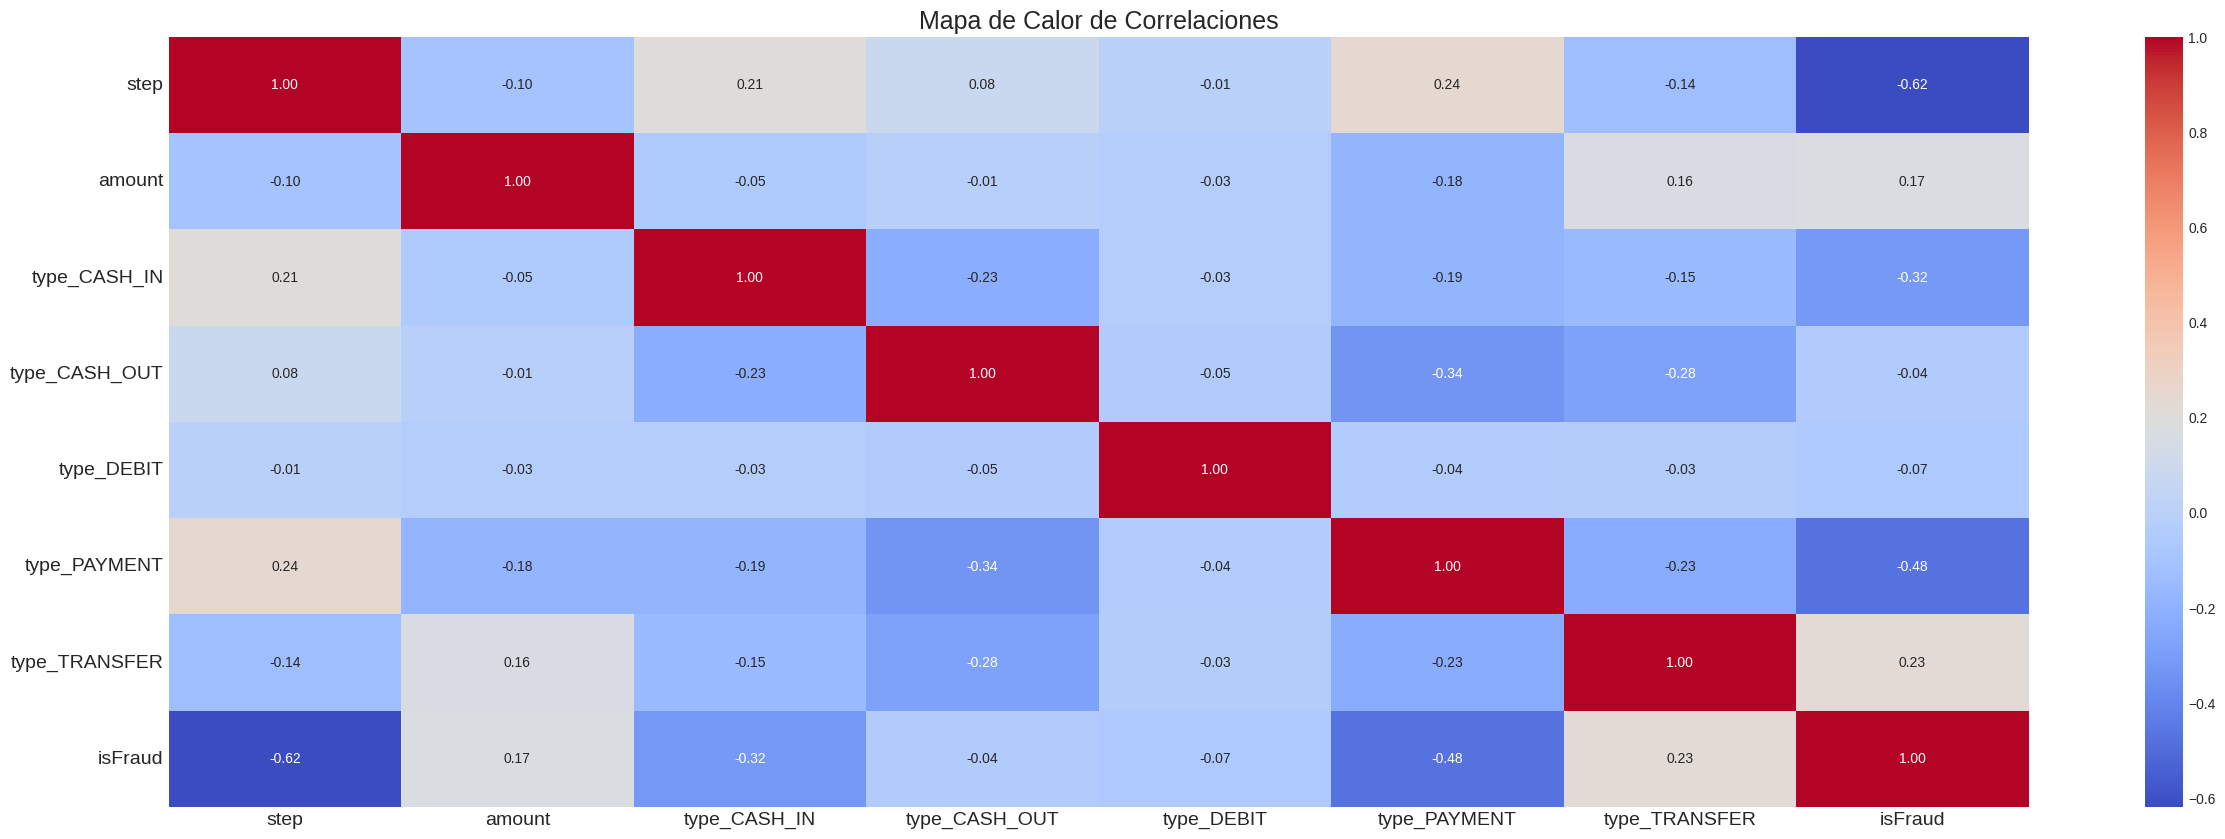

In [ ]:
#Mapa de calor nuevo
plt.figure(figsize=(30, 10))
heatmap = sns.heatmap(df_banco.corr(), annot=True, cmap='coolwarm', fmt=".2f")
heatmap.tick_params(axis='both', which='major', labelsize=14)
plt.title('Mapa de Calor de Correlaciones', fontsize=18)
plt.show()

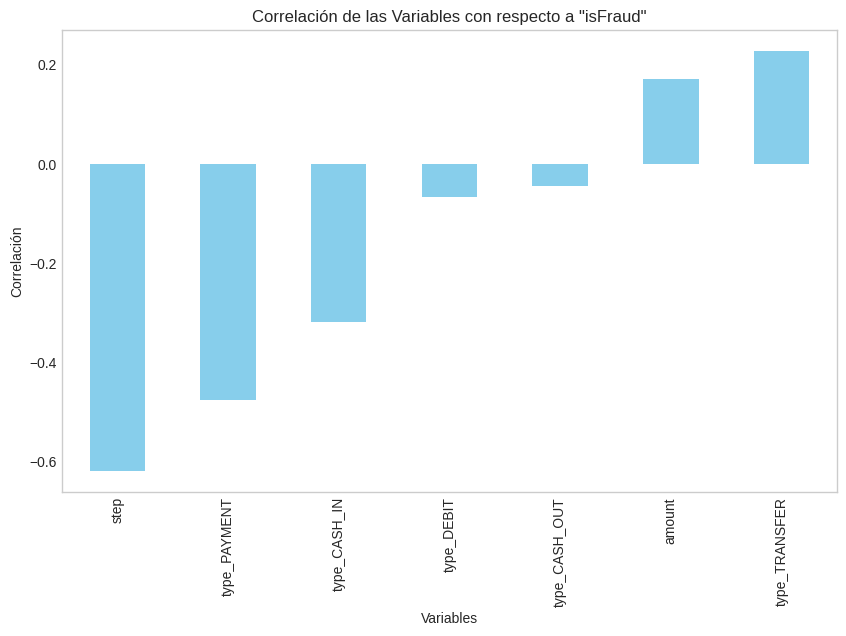

In [ ]:
# Correlación de las variables respecto a 'isFraud' excluyendo la correlación con 'isFraud' misma
correlation_series = df_banco.corr()['isFraud'].drop('isFraud')

# Graficar la correlación
plt.figure(figsize=(10, 6))
correlation_series.sort_values().plot(kind='bar', color='skyblue')
plt.title('Correlación de las Variables con respecto a "isFraud"')
plt.xlabel('Variables')
plt.grid(False)
plt.ylabel('Correlación')
plt.show()

#**4. Construcción de Modelos**


---


In [ ]:
# @title
def crea_modelos():
    global df_banco, resultados

    # Listas para almacenar los valores
    nombre_modelo = []
    accuracy = []
    precision = []
    rc = []
    f1 = []
    auc_roc = []
    matriz_confusion = []
    feature_importances = []
    modelos_entrenados = []

    # Separar datos en características (X) y etiquetas (y)
    X = df_banco.drop(columns='isFraud')
    y = df_banco['isFraud']

    # Normalizar datos
    norm = StandardScaler()
    X_normalizado = norm.fit_transform(X)

    # Definir la lista de modelos
    modelos = [
        ('Regresión Logística', LogisticRegression()),
        ('Random Forest', RandomForestClassifier()),
        ('Arbol Decision', DecisionTreeClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('XGBoost', xgb.XGBClassifier())
    ]

    for nombre, model in modelos:
        # Realizar validación cruzada
        scores = cross_val_score(model, X_normalizado, y, cv=5, scoring='recall')

        # Almacenar la precisión media de la validación cruzada
        acc = scores.mean()

        # Almacenar otros resultados de evaluación utilizando train_test_split como antes
        X_train, X_test, y_train, y_test = train_test_split(X_normalizado, y, test_size=0.3, random_state=77)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        prec = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1_value = f1_score(y_test, predictions)
        auc_roc_value = roc_auc_score(y_test, predictions)
        matriz = confusion_matrix(y_test, predictions)

        # Obtener feature_importances_ y nombres de características
        if hasattr(model, 'feature_importances_'):
            feature_importances.append(dict(zip(X.columns, model.feature_importances_)))
        else:
            feature_importances.append(None)

        # Almacenar valores en listas
        modelos_entrenados.append(model)
        nombre_modelo.append(nombre)
        accuracy.append(acc)
        precision.append(prec)
        rc.append(recall)
        f1.append(f1_value)
        auc_roc.append(auc_roc_value)
        matriz_confusion.append(matriz)

    # Resultados
    resultados = {
        'Nombre_Modelo': nombre_modelo,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': rc,
        'F1_Score': f1,
        'AUC_ROC': auc_roc,
        'Matriz_Confusión': matriz_confusion,
        'Feature_Importances': feature_importances
    }

In [ ]:
crea_modelos()
for i, model in enumerate(resultados['Nombre_Modelo']):
    print(f"Modelo: {model}")
    print(f"Accuracy: {round(resultados['Accuracy'][i], 3)}")
    print(f"Precisión: {round(resultados['Precision'][i], 3)}")
    print(f"Recall: {round(resultados['Recall'][i], 3)}")
    print(f"F1_Score: {round(resultados['F1_Score'][i], 3)}")
    print(f"AUC-ROC: {round(resultados['AUC_ROC'][i], 3)}")
    print(f"Features importances: {resultados['Feature_Importances'][i]}\n")

Modelo: Regresión Logística
Accuracy: 0.934
Precisión: 0.937
Recall: 0.936
F1_Score: 0.936
AUC-ROC: 0.942
Features importances: None

Modelo: Random Forest
Accuracy: 0.971
Precisión: 0.967
Recall: 0.971
F1_Score: 0.969
AUC-ROC: 0.972
Features importances: {'step': 0.3855465141609377, 'amount': 0.2526032871034635, 'type_CASH_IN': 0.0975042153068219, 'type_CASH_OUT': 0.050592073494862125, 'type_DEBIT': 0.009185071570758764, 'type_PAYMENT': 0.1799916956935594, 'type_TRANSFER': 0.024577142669596593}

Modelo: Arbol Decision
Accuracy: 0.97
Precisión: 0.967
Recall: 0.971
F1_Score: 0.969
AUC-ROC: 0.972
Features importances: {'step': 0.494300356395243, 'amount': 0.21227882566936476, 'type_CASH_IN': 0.07461510032746975, 'type_CASH_OUT': 0.03369212375687031, 'type_DEBIT': 0.011242149010877603, 'type_PAYMENT': 0.159574332801081, 'type_TRANSFER': 0.014297112039093578}

Modelo: Naive Bayes
Accuracy: 1.0
Precisión: 0.677
Recall: 1.0
F1_Score: 0.807
AUC-ROC: 0.804
Features importances: None

Modelo: X

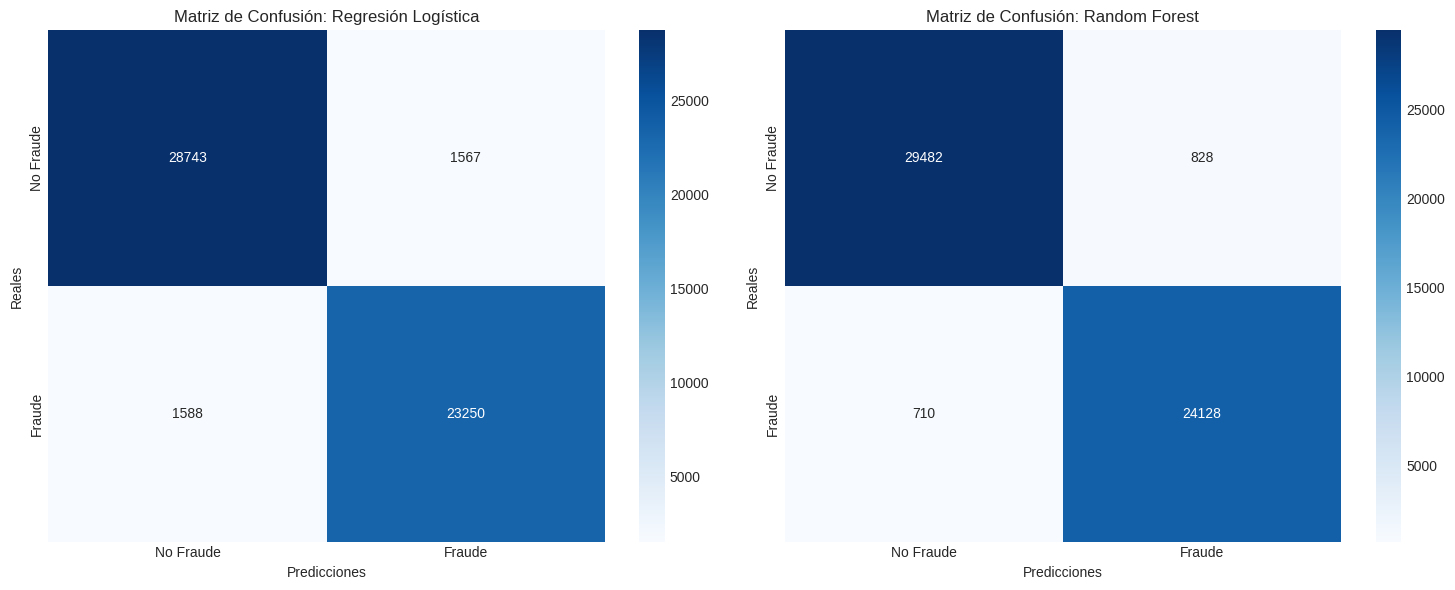

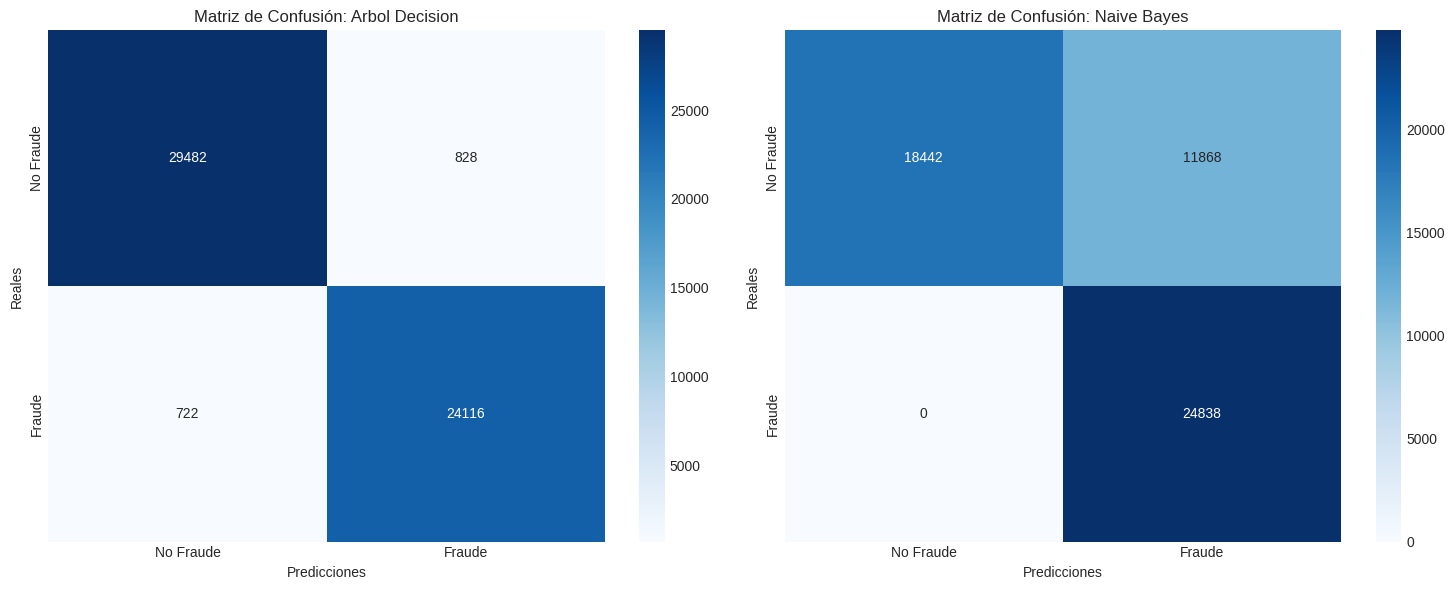

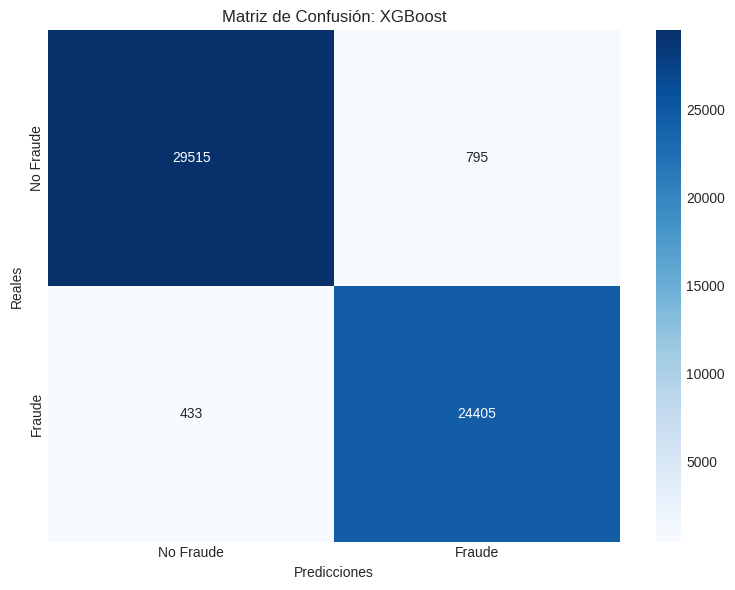

In [ ]:
# @title
for i in range(0, len(resultados['Nombre_Modelo']), 2):
    plt.figure(figsize=(15, 6))

    for j in range(2):
        if i + j < len(resultados['Nombre_Modelo']):
            plt.subplot(1, 2, j + 1)
            matriz = resultados['Matriz_Confusión'][i + j]
            sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues")
            plt.title(f"Matriz de Confusión: {resultados['Nombre_Modelo'][i + j]}")
            plt.xlabel("Predicciones")
            plt.ylabel("Reales")
            plt.gca().set_xticklabels(['No Fraude', 'Fraude'])
            plt.gca().set_yticklabels(['No Fraude', 'Fraude'])

    plt.tight_layout()
    plt.show()

#**5. Evaluación y Selección del Modelo**


---


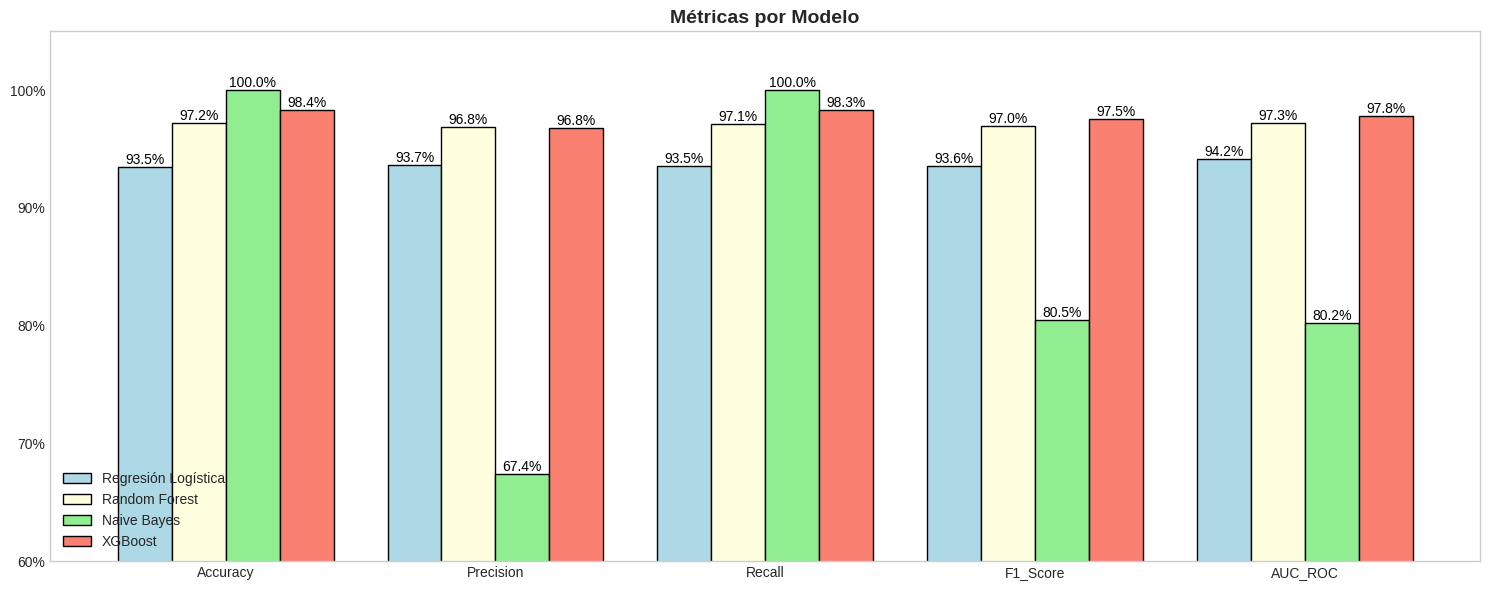

In [ ]:
def visualiza_resultados():
    global df_banco, resultados

    # Transformar resultados a df
    results_df = pd.DataFrame(resultados)

    # Excluir las últimas dos columnas (matriz de confusión y feature_importances)
    results_df = results_df.iloc[:, :-2]
    results_df.set_index('Nombre_Modelo', inplace=True)

    # Transponer df y graficar
    results_df = results_df.T
    colors = ['lightblue', 'lightyellow', 'lightgreen', 'salmon']

    ax = results_df.plot(kind='bar', figsize=(15, 6), colormap='viridis', rot=0, color=colors, width=0.8, edgecolor='black')
    plt.title('Métricas por Modelo', fontsize=14, fontweight='bold')
    plt.ylim(0.6)

    # Formatear valores del eje Y como porcentajes
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

    # Agregar porcentajes encima de cada barra
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.grid(False)
    ax.legend(loc='lower left')
    plt.show()

visualiza_resultados()